### CIFAR-10 データセットを用いて、データ拡張・正規化が精度にどれほど影響を与えるのかを検証。

1. データ拡張なし、画像の正規化なし、バッチ正規化なし
2. 画像のみ正規化、バッチ正規化なし。以下画像は常に正規化
3. データ拡張あり、バッチ正規化なし
4. データ拡張なし、バッチ正規化あり
5. データ拡張あり、バッチ正規化あり

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(0)

## データセットの前処理用パラメータ

In [2]:
# データ拡張なし、正規化なし
train_transform_default = transforms.Compose([
    transforms.ToTensor(),
])
# 正規化のみ
train_transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# データ拡張あり
train_transform_customs = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(
        degrees=(-90, 90),
        fill=0,
        expand=False
        ),
    transforms.RandomErasing(
            p=0.3,
            scale=(0.02, 0.33),
            ratio=(0.3, 3.3),
            value=0,
        ),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 検証、評価用。正規化なし
test_transform_default = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# 検証、評価用。正規化あり
test_transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
# CIFAR-10 のデータを用意する関数
def data_load(train_transform, test_transform):
    """
    Args:
        transform : 前処理のパラメータ。デフォルトでは拡張なし

    Returns:
        dataset: ソフトマックス関数を適用した結果。
        
    """
    full_trainset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=train_transform)
    full_trainset_val = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=test_transform)
    # 学習データと検証データの分割 (8:2)
    train_size = int(0.8 * len(full_trainset_train))
    val_size = len(full_trainset_train) - train_size
    
    generator = torch.Generator().manual_seed(0)
    trainset, _ = random_split(full_trainset_train, [train_size, val_size], generator=generator)
    _, valset = random_split(full_trainset_val, [train_size, val_size], generator=generator)

    trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
    valloader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=test_transform)
    testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)
    
    return trainloader,valloader, testloader

## 正規化なしのネットワークを定義
1. Conv2d(32フィルタ, 3x3)  → ReLU → MaxPool
2. Conv2d(64フィルタ, 3x3)  → ReLU → MaxPool
3. Conv2d(128フィルタ, 3x3) → ReLU → MaxPool
4. 全結合層 (128 → 256) → ReLU
5. 全結合層 (256 → 10) → Softmax

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## 正規化ありのネットワークを定義
1. Conv2d(32フィルタ, 3x3) → BatchNorm → ReLU → MaxPool
2. Conv2d(64フィルタ, 3x3) → BatchNorm → ReLU → MaxPool
3. Conv2d(128フィルタ, 3x3) → BatchNorm → ReLU → MaxPool
4. 全結合層 (128 → 256) → ReLU
5. 全結合層 (256 → 10) → Softmax

In [5]:
class CNN_Norm(nn.Module):
    def __init__(self):
        super(CNN_Norm, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [6]:
def calculate_accuracy_and_loss(loader, model, criterion):
    correct = 0
    total = 0
    total_loss = 0.0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_loss += loss.item()
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(loader)
    return accuracy, avg_loss

In [7]:
def train_and_test(train_transform, test_transform, is_norm:bool) -> dict:
    if is_norm == False:
        model = CNN()
    else:
        model = CNN_Norm()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    trainloader,valloader, testloader = data_load(train_transform, test_transform)
    
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    
    for epoch in range(20):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 500 == 499:
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0
        
    # 学習データと検証データの精度と損失計算
        model.eval()
        train_acc, train_loss = calculate_accuracy_and_loss(trainloader, model, criterion)
        val_acc, val_loss = calculate_accuracy_and_loss(valloader, model, criterion)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print("*-"*50)
        print(f'Epoch {epoch + 1}: Training Accuracy: {train_acc:.2f}%, Training Loss: {train_loss:.3f}, Validation Accuracy: {val_acc:.2f}%, Validation Loss: {val_loss:.3f}')
        print("*-"*50)
        # テスト精度の計算
        test_acc, test_loss = calculate_accuracy_and_loss(testloader, model, criterion)
        print(f'Accuracy on the 10000 test images: {test_acc:.2f}%, Test Loss: {test_loss:.3f}')
    return {
        "train_accuracies":train_accuracies,
        "val_accuracies":val_accuracies,
        "train_losses":train_losses, 
        "val_losses":val_losses,
        "test_acc":test_acc,
        "test_loss":test_loss
        }

In [8]:
def show_result(result:dict):
    # テストデータの精度
    print(f"Test Accuracy:{result['test_acc']}% | Test Loss:{result['test_loss']}")
    
    # 学習過程のグラフ
    epochs = range(1, 21)
    plt.figure(figsize=(12, 5))

    # 精度のグラフ
    plt.subplot(1, 2, 1)
    plt.plot(epochs, result["train_accuracies"], label='Training Accuracy')
    plt.plot(epochs, result["val_accuracies"], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # 損失のグラフ
    plt.subplot(1, 2, 2)
    plt.plot(epochs, result["train_losses"], label='Training Loss')
    plt.plot(epochs, result["val_losses"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    

## 1.データ拡張なし、正規化なし

In [9]:
result_train_normal_not_norm = train_and_test(train_transform_default, test_transform_default, False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1, Batch 500] loss: 8.708
[Epoch 1, Batch 1000] loss: 6.841
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Epoch 1: Training Accuracy: 58.75%, Training Loss: 1.151, Validation Accuracy: 40.83%, Validation Loss: 1.939
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Accuracy on the 10000 test images: 40.49%, Test Loss: 1.951
[Epoch 2, Batch 500] loss: 5.589
[Epoch 2, Batch 1000] loss: 5.314
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Epoch 2: Training Accuracy: 66.86%, Training Loss: 0.945, Validation Accuracy: 45.75%, Validation Loss: 2.025
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Accuracy on the 10000 test images: 44.81%, Test Loss: 2.076
[Epoch 3

Test Accuracy:45.18% | Test Loss:8.984393994267375


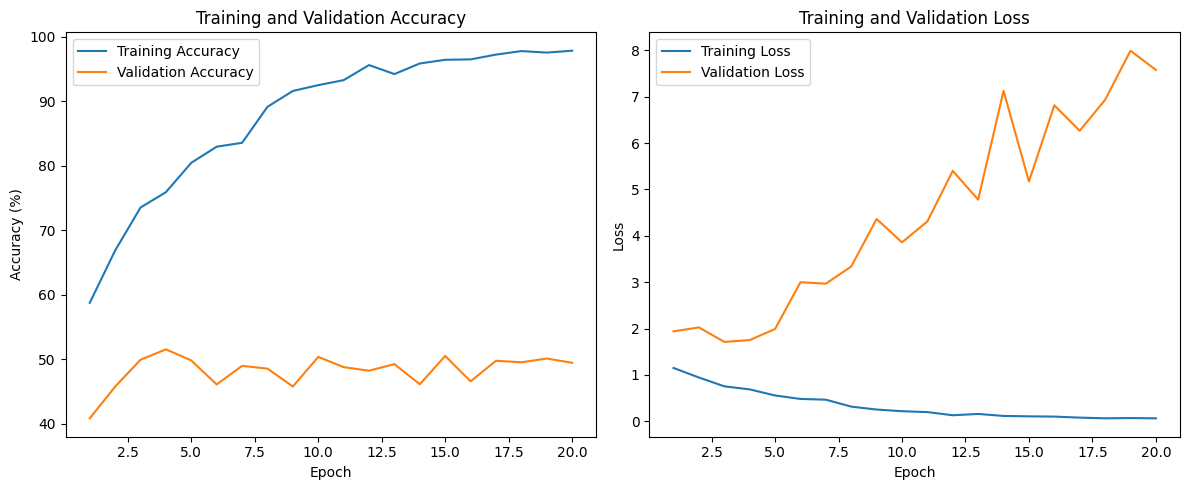

In [10]:
show_result(result_train_normal_not_norm)

#### 評価データ・検証データの精度がおよそ50%、かなり過学習していることがわかる
#### 検証データの損失も増加し続けている

## 2. 画像のみ正規化を加えてみる。（バッチ正規化なし）
#### 以後画像の正規化は常にする

In [11]:
result_img_norm = train_and_test(train_transform_norm, test_transform_norm, False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1, Batch 500] loss: 8.072
[Epoch 1, Batch 1000] loss: 6.191
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Epoch 1: Training Accuracy: 64.19%, Training Loss: 1.009, Validation Accuracy: 63.07%, Validation Loss: 1.034
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Accuracy on the 10000 test images: 61.97%, Test Loss: 1.072
[Epoch 2, Batch 500] loss: 4.940
[Epoch 2, Batch 1000] loss: 4.585
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Epoch 2: Training Accuracy: 71.01%, Training Loss: 0.824, Validation Accuracy: 70.04%, Validation Loss: 0.856
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Accuracy on the 10000 test images: 66.40%, Test Loss: 0.954
[Epoch 3

Test Accuracy:72.4% | Test Loss:1.915298816114188


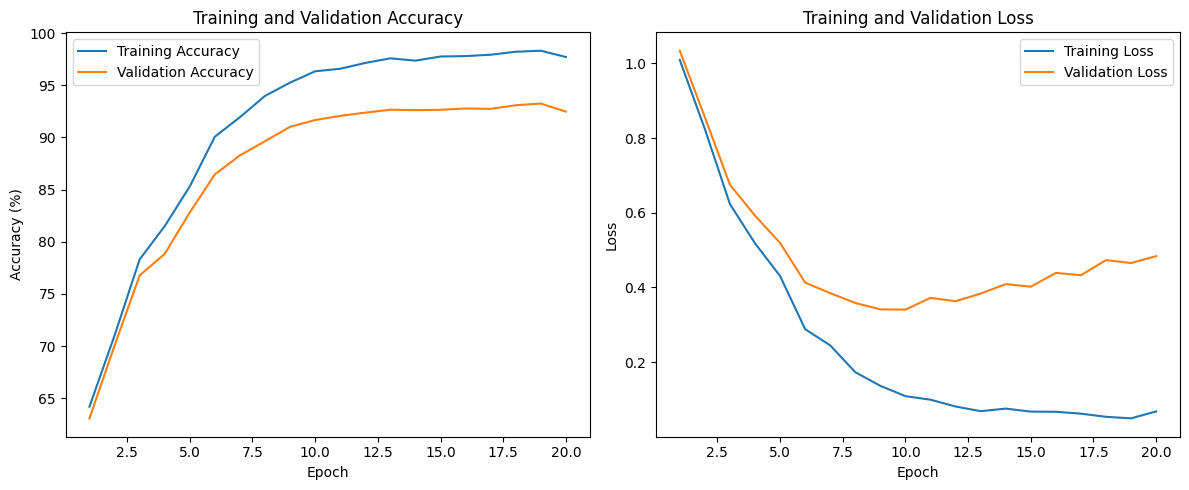

In [12]:
show_result(result_img_norm)

### 評価データでの精度が70%。10回目あたりから検証データの損失が増加している。
#### 何もしないより精度は上がったが、まだ過学習しているように見える

## 3. データ拡張あり、バッチ正規化なし

In [13]:
result_custom_not_norm = train_and_test(train_transform_customs, test_transform_norm, False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1, Batch 500] loss: 10.123
[Epoch 1, Batch 1000] loss: 8.972
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Epoch 1: Training Accuracy: 39.98%, Training Loss: 1.659, Validation Accuracy: 42.06%, Validation Loss: 1.602
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Accuracy on the 10000 test images: 42.89%, Test Loss: 1.584
[Epoch 2, Batch 500] loss: 8.302
[Epoch 2, Batch 1000] loss: 8.050
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Epoch 2: Training Accuracy: 42.95%, Training Loss: 1.572, Validation Accuracy: 48.77%, Validation Loss: 1.437
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Accuracy on the 10000 test images: 49.03%, Test Loss: 1.424
[Epoch 

Test Accuracy:63.53% | Test Loss:1.036705745294833


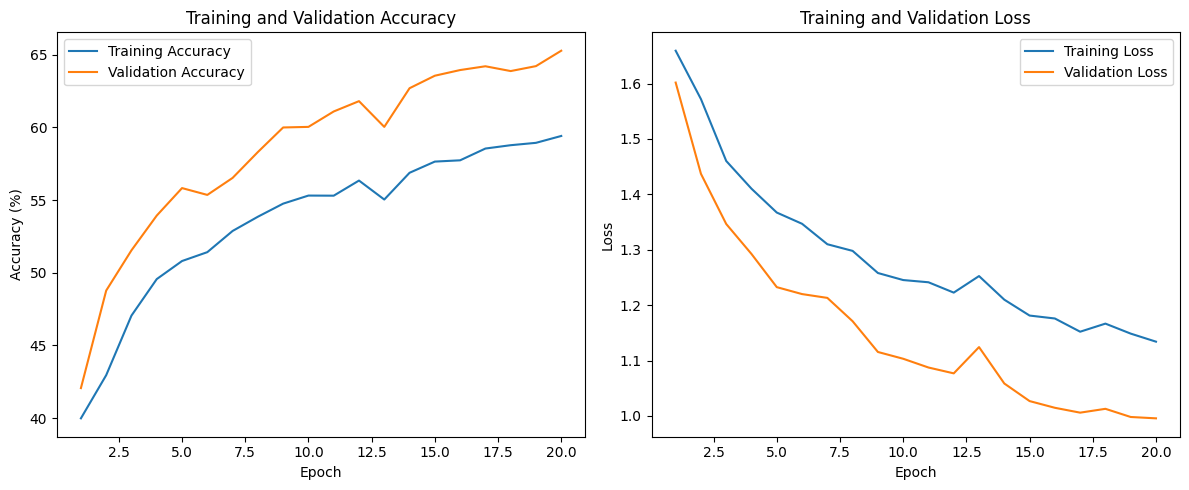

In [14]:
show_result(result_custom_not_norm)

#### 精度がすごく下がった・・・？学習データの正答率の方が低いのも気になる
#### データ拡張の内容がよくなかったのかもしれない

## 4. データ拡張なし、バッチ正規化あり

In [15]:
result_norm = train_and_test(train_transform_norm, test_transform_norm, True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1, Batch 500] loss: 7.206
[Epoch 1, Batch 1000] loss: 5.558
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Epoch 1: Training Accuracy: 64.19%, Training Loss: 1.014, Validation Accuracy: 63.35%, Validation Loss: 1.028
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Accuracy on the 10000 test images: 62.68%, Test Loss: 1.077
[Epoch 2, Batch 500] loss: 4.383
[Epoch 2, Batch 1000] loss: 4.173
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Epoch 2: Training Accuracy: 76.18%, Training Loss: 0.695, Validation Accuracy: 74.92%, Validation Loss: 0.725
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Accuracy on the 10000 test images: 72.16%, Test Loss: 0.811
[Epoch 3

Test Accuracy:76.9% | Test Loss:1.2599174727361424


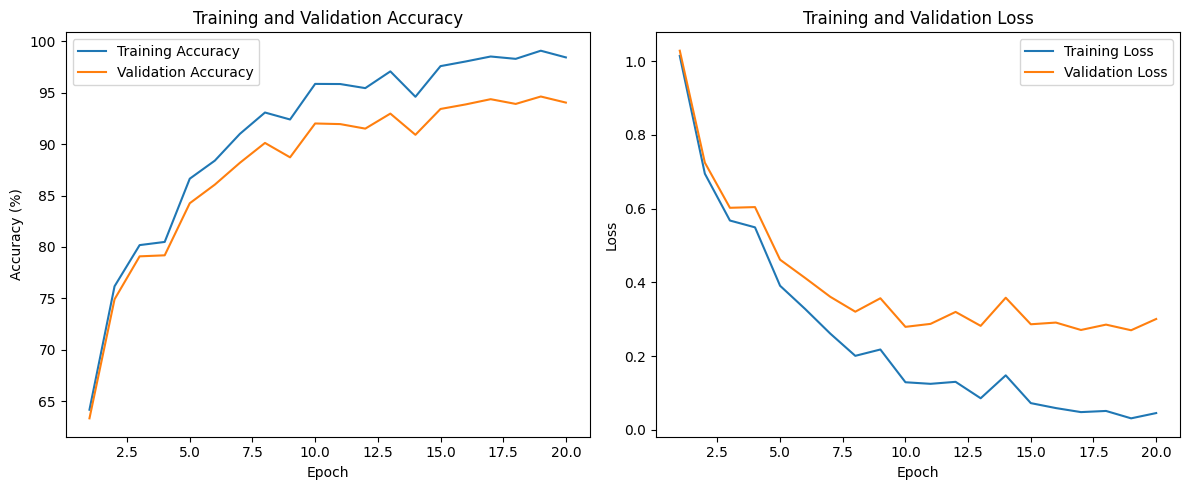

In [16]:
show_result(result_norm)

#### 評価データでの精度75%
#### かなりよくなっている。10回目あたりから損失関数が増加しているため、10回くらいが適正？

## 5. データ拡張あり、バッチ正規化あり

In [17]:
result_custom_and_norm = train_and_test(train_transform_customs, test_transform_norm, True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1, Batch 500] loss: 9.431
[Epoch 1, Batch 1000] loss: 8.522
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Epoch 1: Training Accuracy: 41.73%, Training Loss: 1.611, Validation Accuracy: 46.93%, Validation Loss: 1.474
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Accuracy on the 10000 test images: 46.75%, Test Loss: 1.464
[Epoch 2, Batch 500] loss: 7.994
[Epoch 2, Batch 1000] loss: 7.755
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Epoch 2: Training Accuracy: 45.93%, Training Loss: 1.491, Validation Accuracy: 50.97%, Validation Loss: 1.365
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Accuracy on the 10000 test images: 50.54%, Test Loss: 1.365
[Epoch 3

Test Accuracy:68.27% | Test Loss:0.9220445158953865


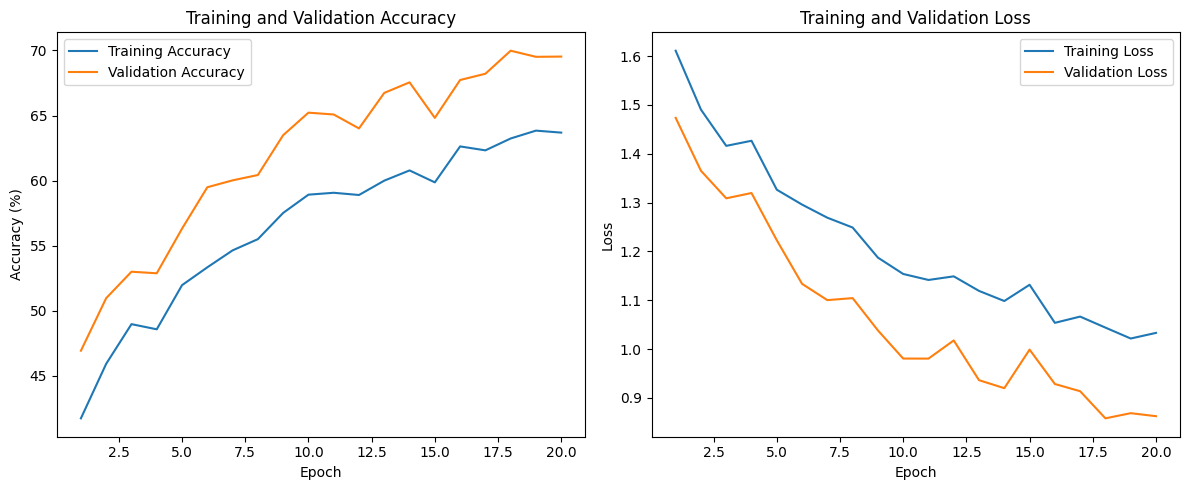

In [18]:
show_result(result_custom_and_norm)

#### 3と同様で学習データの正答率の方が低い、、、？
#### データの拡張が悪さしているのだろうか
 ➡ RandomErasingで重要な部分が消えていて予測できない？

### 仮説
- 特定の拡張手法が精度を下げている。➡RandomErasingで重要な部分が消えている？
- バッチサイズに対して拡張の種類が多すぎる？

## ex_1 前処理方法を変更

In [21]:
# 画像の変化の大きい、RandomErasingとRandomRotationを削除
train_transform_customs_fixed = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [22]:
result_custom_and_norm_fixed = train_and_test(train_transform_customs_fixed, test_transform_norm, True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1, Batch 500] loss: 8.102
[Epoch 1, Batch 1000] loss: 6.686
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Epoch 1: Training Accuracy: 53.45%, Training Loss: 1.296, Validation Accuracy: 54.64%, Validation Loss: 1.267
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Accuracy on the 10000 test images: 54.19%, Test Loss: 1.288
[Epoch 2, Batch 500] loss: 5.581
[Epoch 2, Batch 1000] loss: 5.218
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Epoch 2: Training Accuracy: 66.11%, Training Loss: 0.947, Validation Accuracy: 68.66%, Validation Loss: 0.868
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Accuracy on the 10000 test images: 68.37%, Test Loss: 0.883
[Epoch 3

Test Accuracy:81.72% | Test Loss:0.5503049300263484


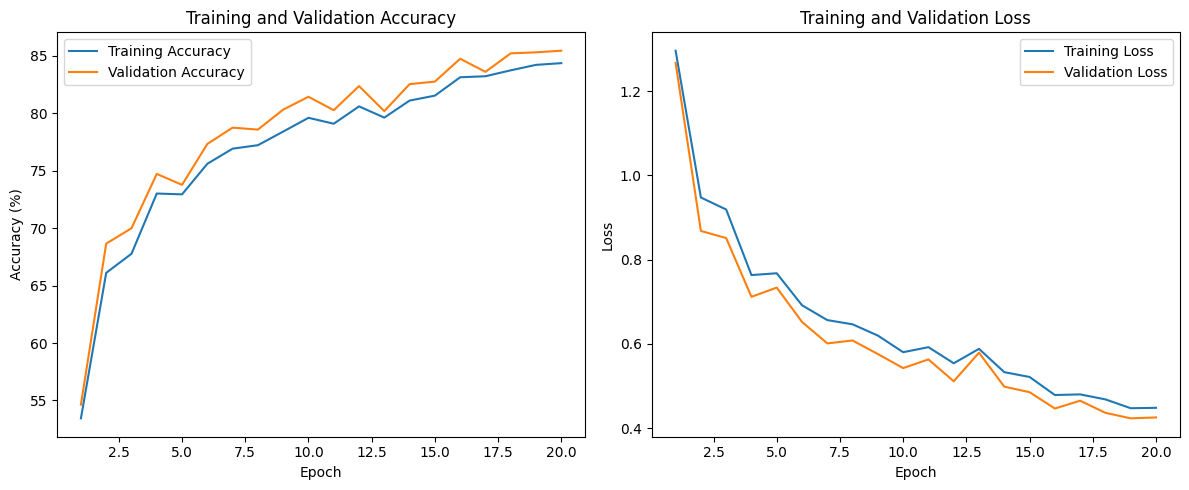

In [23]:
show_result(result_custom_and_norm_fixed)

#### 精度向上、まだ学習データの正答率の方が低い

評価データの正答率はこれまでで最も高く80%を超えた。学習・検証データの正答率にも近い

## ex_2 前処理をさらに減らす

In [25]:
# HorizontalFlipのみにしてみる
train_transform_customs_fixed_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [26]:
result_custom_and_norm_fixed_2 = train_and_test(train_transform_customs_fixed_2, test_transform_norm, True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1, Batch 500] loss: 7.210
[Epoch 1, Batch 1000] loss: 5.473
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Epoch 1: Training Accuracy: 65.52%, Training Loss: 0.970, Validation Accuracy: 64.79%, Validation Loss: 0.985
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Accuracy on the 10000 test images: 64.23%, Test Loss: 1.012
[Epoch 2, Batch 500] loss: 4.591
[Epoch 2, Batch 1000] loss: 4.252
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Epoch 2: Training Accuracy: 72.34%, Training Loss: 0.781, Validation Accuracy: 71.48%, Validation Loss: 0.799
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Accuracy on the 10000 test images: 69.97%, Test Loss: 0.856
[Epoch 3

Test Accuracy:79.35% | Test Loss:0.7789221935854933


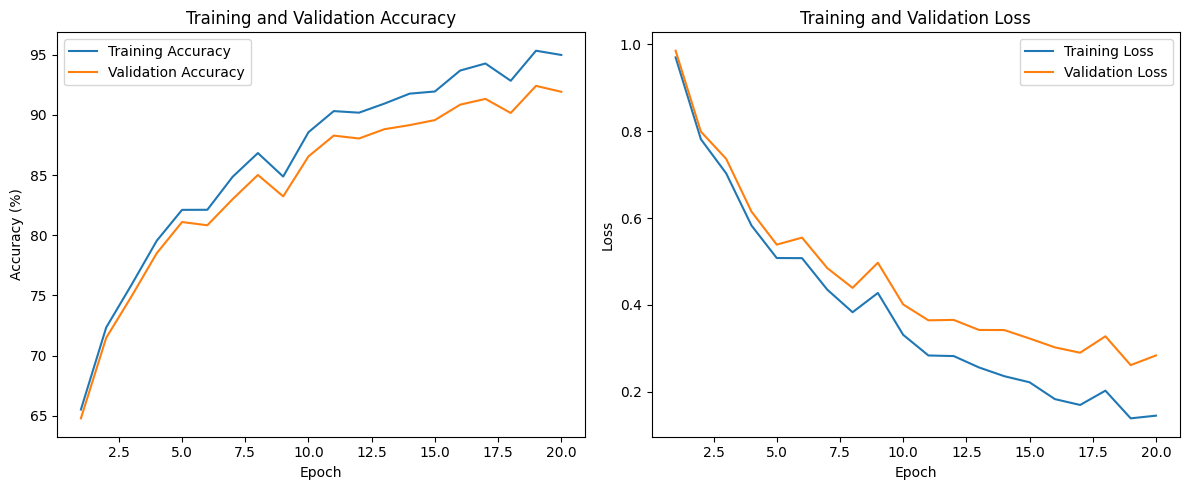

In [27]:
show_result(result_custom_and_norm_fixed_2)

#### 学習データ、検証データの正答率が向上。

評価データの正答率は少し下がった<br>
過学習の度合いを見ると、RandomCropもあった方がよい

## 結果
- 入力データを正規化するだけでも過学習がかなり抑えられる
- データ拡張はやればやるだけいいわけではない。
   - データの数や特性で判断するのがよさそう
   - 今回はバッチサイズが小さかったためより強く影響をうけた？

## 今後の展望
バッチサイズやエポック数、中間層を増やして検証をしてみたい。<br>
ただ、今回のモデルでもCPUでの学習には限界を感じた。<br>
画像認識のコンペに出るにはまずGPUを用意する必要がありそう。RTX5000シリーズ検討してみようかな。。。<br>